<p align="center">
    <img width=210 height=150 src="../reports/figures/cunef_bw.png">
</p>

<div>
<h1>3.0 Models </h1>
Fake News Classifier <br>
<strong>Ciencia de Datos para la Información No Estructurada</strong> <br>
<strong>Master Universidatio en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---

A continuación vamos a crear los distintos modelos para evaluar la detección de noticias falsas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import string
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# Metrics
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score
import scikitplot as skplt

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline



Ahora procederemos a crear las funciones que agilizaran la ejecución y evaluación de los modelos.
Las siguientes funciones nos permitiran graficar las matrices de confusión y curvas del modelo. No lo haremos para todos pero si para aquellos que consideremos relevantes.

In [2]:
# Ploting functions for the models
def confusion_matrix(titles_options = None, test = None, pred = None, labels = None):
    '''
    Prints confusion matrix making the predictions
    :param titles_options:
    :param test:
    :param pred:
    :param labels:
    :return:
    '''
    for title, normalize in titles_options:
        disp = metrics.ConfusionMatrixDisplay.from_predictions(
            test,
            pred,
            display_labels=labels,
            cmap=plt.cm.Blues,
            normalize=normalize
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

def model_curves_summary(test = None, pred = None, label = 'Model'):
    '''
    Prints a plot report with four different plots: ROC curve, PR curve,
    Gain curve, Lift curve
    :param test: Real values
    :param pred: Predicted values
    :param label: Model name
    '''
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
    fig.suptitle('Curvas del modelo ' + label)

    # ROC CURVE
    fpr, tpr, thresholds = metrics.roc_curve(test, pred[:,1])
    # plot the roc curve for the model
    axes[0,0].plot([0,1], [0,1], linestyle='--', label='No Skill')
    axes[0,0].plot(fpr, tpr, marker='.', label=label)
    # axis labels
    axes[0,0].set_title('Curva ROC')
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].legend()
    axes[0,0].grid()

    # Precission-Recall CURVE
    # calculate pr-curve
    precision, recall, thresholds = metrics.precision_recall_curve(test, pred[:,1])
    no_skill = len(test[test==1]) / len(test)
    axes[0,1].plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    axes[0,1].plot(recall, precision, marker='.', label=label)
    # axis labels
    axes[0,1].set_title('Curva Precission-Recall')
    axes[0,1].set(xlabel='Precission', ylabel='Recall')
    axes[0,1].legend()
    axes[0,1].grid()

    # GAIN CURVE
    skplt.metrics.plot_cumulative_gain(test, pred, ax = axes[1,0])

    # LIFT CURVE
    skplt.metrics.plot_lift_curve(test, pred, ax = axes[1,1])

Ahora crearemos una función de evaluación de los modelos para generar una tabla resumen de su funcionamiento. Esta función entrenará el modelo y lo evaluarará devolviendo para cada uno los valores el accuracy, la precisión, el recall. Además calcularemos también el F-score y el area de la curva ROC (AUC).

In [3]:
# Metrics list
models_report_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precission', 'Recall', 'F-score', 'AUC'])

# Model final list for later use
models_collection_titles = {} #1
models_collection_texts = {} #2

def model_train_test(model, model_col, traind, traind_labels, testd, testd_labels, data_info, i):
    model_name = str(type(model).__name__) + data_info

    # Training model
    print("Training model... " + model_name)
    model.fit(traind, traind_labels)

    # Prediction with model
    print("Predicting with model... " + model_name)
    y_pred = model.predict(testd)
    
    # Model information
    models_report_df.loc[i] = [
        model_name,
        metrics.accuracy_score(testd_labels, y_pred),
        metrics.precision_score(testd_labels, y_pred),
        metrics.recall_score(testd_labels, y_pred),
        metrics.f1_score(testd_labels, y_pred),
        metrics.roc_auc_score(testd_labels, y_pred)
    ]

    # Saving the model
    if model_col == 1:
      models_collection_titles[model_name] = model
    else: 
      models_collection_texts[model_name] = model

    print("Ended evaluation of model... " + model_name)

Ahora recuperaremos los datos para evaluar a los modelos. Realizaremos evaluaciones tanto con el preprocesado para titulos de noticias como el preprocesado de textos de noticias...

In [5]:
# Data preprocessed for titles
train_titles = pd.read_csv("../data/processed/train_titles.csv")
test_titles = pd.read_csv("../data/processed/test_titles.csv")

Y_train_titles = train_titles['label']
X_train_titles = train_titles.drop(['label'], axis=1)

Y_test_titles = test_titles['label']
X_test_titles = test_titles.drop(['label'], axis=1)

# Data preprocessed for texts 
train_text = pd.read_csv("../data/processed/train_text.csv")
test_text = pd.read_csv("../data/processed/test_text.csv")

Y_train_text = train_text['label']
X_train_text = train_text.drop(['label'], axis=1)

Y_test_text = test_text['label']
X_test_text = test_text.drop(['label'], axis=1)


Primero comenzaremos con los modelos para los datos con preprocesado para títulos, en este caso utilizaremos un Árbol de decisión como modelo básico, un RandomForest, un SVM, un Multinomial Naive Bayes y un clasificador GradientBosting como modelos más avanzados.

In [9]:
models = [tree.DecisionTreeClassifier(), RandomForestClassifier(), svm.SVC(), MultinomialNB(), GradientBoostingClassifier()]

for i, m in enumerate(models):
    model_train_test(m, 1, X_train_titles, Y_train_titles, X_test_titles, Y_test_titles, "_titles", i+5)

Training model... DecisionTreeClassifier_titles
Predicting with model... DecisionTreeClassifier_titles
Ended evaluation of model... DecisionTreeClassifier_titles
Training model... RandomForestClassifier_titles
Predicting with model... RandomForestClassifier_titles
Ended evaluation of model... RandomForestClassifier_titles
Training model... SVC_titles
Predicting with model... SVC_titles


C:\Users\carviagu\anaconda3\envs\NSD\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ended evaluation of model... SVC_titles
Training model... MultinomialNB_titles
Predicting with model... MultinomialNB_titles
Ended evaluation of model... MultinomialNB_titles
Training model... GradientBoostingClassifier_titles
Predicting with model... GradientBoostingClassifier_titles
Ended evaluation of model... GradientBoostingClassifier_titles


Ahora generaremos modelos con la implementación para textos, en este caso utilizaremos los mismos modelos modelos vistos anteriormente. 

In [7]:
models = [tree.DecisionTreeClassifier(), RandomForestClassifier(), svm.SVC(), MultinomialNB(), GradientBoostingClassifier()]

for i, m in enumerate(models):
    model_train_test(m, 2, X_train_text, Y_train_text, X_test_text, Y_test_text, "_text", i)

Training model... DecisionTreeClassifier_text
Predicting with model... DecisionTreeClassifier_text
Ended evaluation of model... DecisionTreeClassifier_text
Training model... RandomForestClassifier_text
Predicting with model... RandomForestClassifier_text
Ended evaluation of model... RandomForestClassifier_text
Training model... SVC_text
Predicting with model... SVC_text


C:\Users\carviagu\anaconda3\envs\NSD\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ended evaluation of model... SVC_text
Training model... MultinomialNB_text
Predicting with model... MultinomialNB_text
Ended evaluation of model... MultinomialNB_text
Training model... GradientBoostingClassifier_text
Predicting with model... GradientBoostingClassifier_text
Ended evaluation of model... GradientBoostingClassifier_text


Veamos los resultados de todos los modelos generados...

In [10]:
models_report_df

,Model,Accuracy,Precission,Recall,F-score,AUC
0,DecisionTreeClassifier_text,0.846477,0.839506,0.857143,0.848233,0.846466
1,RandomForestClassifier_text,0.912723,0.920771,0.903361,0.911983,0.912733
2,SVC_text,0.499474,0.000000,0.000000,0.000000,0.500000
3,MultinomialNB_text,0.821241,0.743631,0.981092,0.846014,0.821073
4,GradientBoostingClassifier_text,0.901157,0.930180,0.867647,0.897826,0.901192
5,DecisionTreeClassifier_titles,0.724501,0.701128,0.783613,0.740079,0.724438
6,RandomForestClassifier_titles,0.803365,0.810753,0.792017,0.801275,0.803377
7,SVC_titles,0.499474,0.000000,0.000000,0.000000,0.500000
8,MultinomialNB_titles,0.807571,0.781190,0.855042,0.816449,0.807521
9,GradientBoostingClassifier_titles,0.752892,0.839437,0.626050,0.717208,0.753025


Observamos que los datos son bastante prometedores para los modelos que utilizan la configuración de texto completo (text). 

Matriz de confusión
[[438  37]
 [ 46 430]]
Matriz de confusión normalizada
[[0.92210526 0.07789474]
 [0.09663866 0.90336134]]


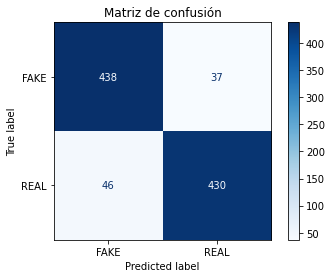

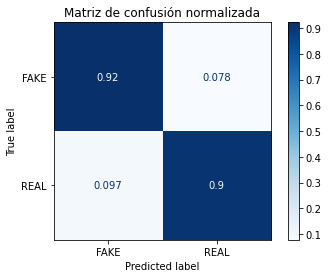

In [11]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
confusion_matrix(titles_options, Y_test_text, models_collection_texts['RandomForestClassifier_text'].predict(X_test_text), 
                            ['FAKE', 'REAL'])

Matriz de confusión
[[387  88]
 [ 84 392]]
Matriz de confusión normalizada
[[0.81473684 0.18526316]
 [0.17647059 0.82352941]]


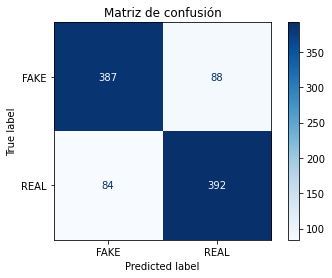

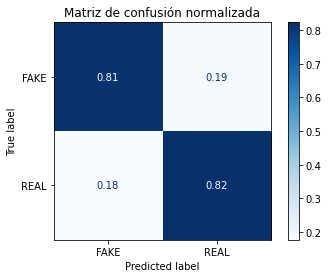

In [ ]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
confusion_matrix(titles_options, Y_test_bow, models_collection['MultinomialNB_bow'].predict(X_test_bow), 
                            ['FAKE', 'REAL'])

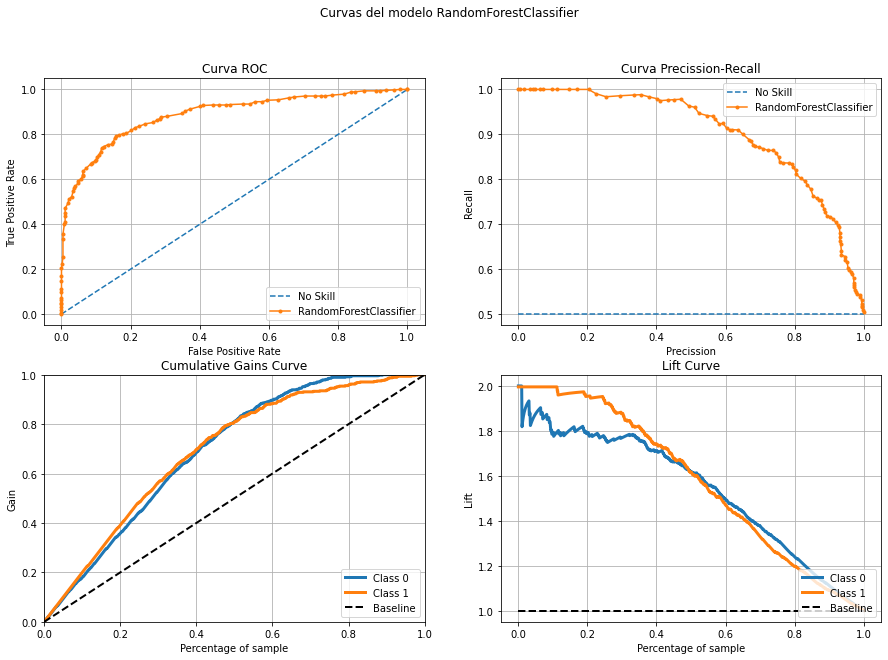

In [ ]:
model_curves_summary(Y_test_tfd, models_collection['RandomForestClassifier_tfid'].predict_proba(X_test_tfd), "RandomForestClassifier")

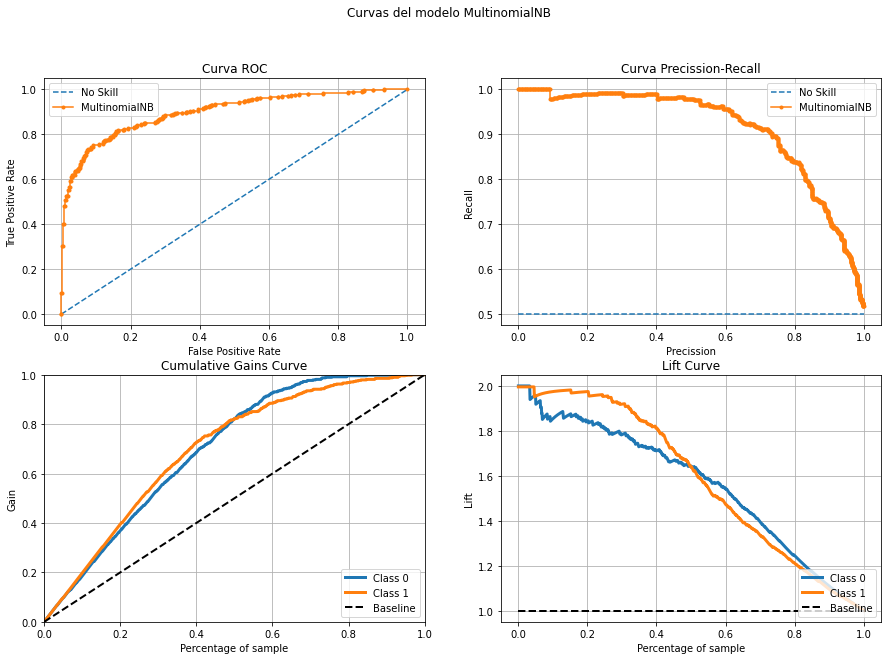

In [ ]:
model_curves_summary(Y_test_bow, models_collection['MultinomialNB_bow'].predict_proba(X_test_bow), "MultinomialNB")

Nos quedamso con el modelo Multinomial Naive Bayes por su equilibrio en las predicciones realizadas. 
Procedemos a generar el pipeline del modelo con las principales características del preprocesado para proceder a optimizarlo y generar el modelo final.

In [ ]:

def cleaning_data(tlt_df):
    # Translator to clean data 
    translator = str.maketrans('', '', string.punctuation)

    # Word lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()

    # Stopwords
    stopwords = nltk.corpus.stopwords.words('english')

    return tlt_df.map(lambda x : " ".join(
        [wordnet_lemmatizer.lemmatize(word, pos="v") for word in 
        re.sub(r"[^a-zA-Z0-9]", " ", x.strip().lower().translate(translator)).split() if not word in stopwords])
)

estimator_model =  make_pipeline(CountVectorizer(), MultinomialNB())

Leemos los datos oiriginales de train para entrenar el modelo y optimizarlo, además definimos los principales hiperparámetros a modificar. Mediante GridSearch se realizará una validación cruzada de las distintas combinaciones y así determinar el mejor resultado. Nos centraremos en evaluar el Recall del modelo y  mejoras las predicciones. 

In [ ]:
train_full = pd.read_csv("../data/interim/train.csv")
Y_train = train_full['label'].str.replace("FAKE", "0").str.replace("REAL", "1").map(lambda x : int(x))
X_train = cleaning_data(train_full.drop(['label'], axis=1)['title'])

In [ ]:
param_grid = {
    'countvectorizer__binary': [True, False],
    "multinomialnb__alpha": [0.01, 0.05, 0.1, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 1, 1.25, 1.5, 1.75, 2],
    "multinomialnb__fit_prior": [True, False]
}

search = GridSearchCV(estimator_model, param_grid, scoring="recall")

In [ ]:
result = search.fit(X_train, Y_train)

In [ ]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.847495361781076
Best Hyperparameters: {'countvectorizer__binary': True, 'multinomialnb__alpha': 1.75, 'multinomialnb__fit_prior': True}


El mejor modelo posee los hiperparámetros que devuelve el tuneado. Ahora crearemos el modelo final en el pipeline con los hiperparámetros que hemos definido. 

In [ ]:
final_model = Pipeline(
    [('vector', CountVectorizer(binary=True)),
    ('model', MultinomialNB(alpha=0.75, fit_prior=False))]
)

final_model.fit(X_train, Y_train)

Pipeline(steps=[('vector', CountVectorizer(binary=True)),
                ('model', MultinomialNB(alpha=0.75, fit_prior=False))])

Vamos a determiar el score final de accuracy del modelo que hemos obtenido finalmente.

In [ ]:
test_full = pd.read_csv("../data/interim/test.csv")
Y_test = test_full['label'].str.replace("FAKE", "0").str.replace("REAL", "1").map(lambda x : int(x))
X_test = cleaning_data(test_full.drop(['label'], axis=1)['title'])

In [ ]:
Y_pred = final_model.predict(X_test)

In [ ]:
metrics.accuracy_score(Y_test, Y_pred)

0.8128286014721346

Matriz de confusión
[[369 106]
 [ 72 404]]
Matriz de confusión normalizada
[[0.77684211 0.22315789]
 [0.1512605  0.8487395 ]]


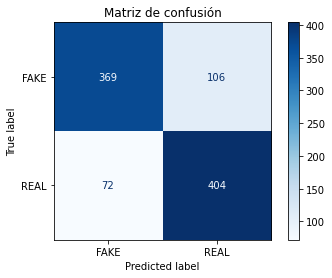

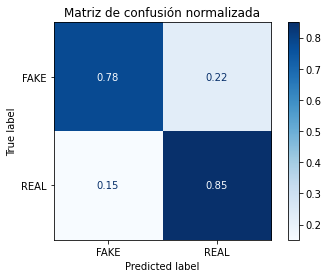

In [ ]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['FAKE', 'REAL'])

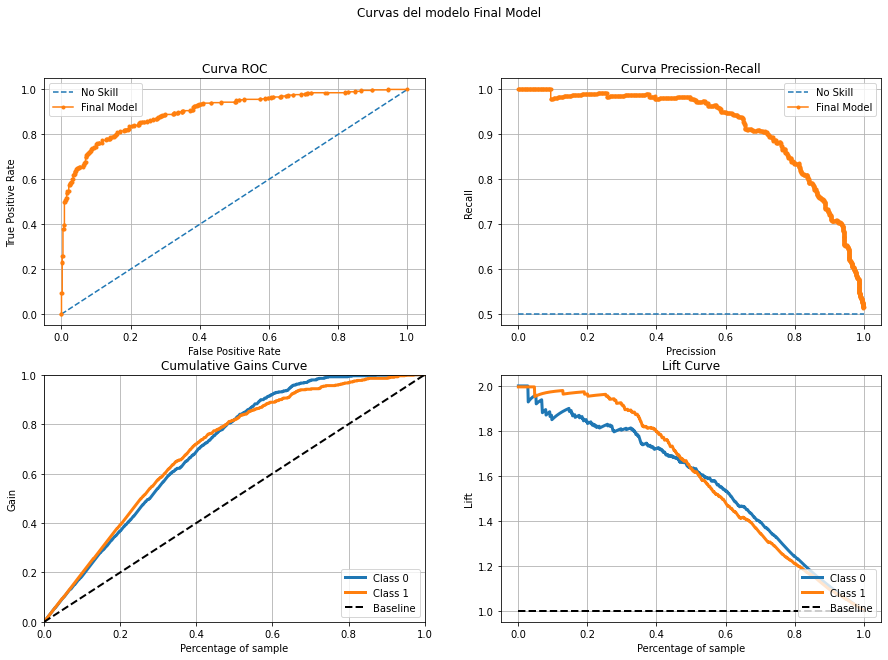

In [ ]:
model_curves_summary(Y_test, final_model.predict_proba(X_test), "Final Model")

Guardamos el modelo mediante pickle para poder usarlo más adelante y productivizarlo.

In [ ]:
file_name = "../models/fake_class_model.sav"
pickle.dump(final_model, open(file_name, "wb"))

---
<div style='text-align:center'> Elaborado por Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>